In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as mpatches

matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["axes.linewidth"] = 1  # set the value globally
plt.rcParams["figure.figsize"] = (14, 10)
plt.rcParams["font.size"] = "18"

import argparse
import glob, os, sys
import numpy as np

from scipy.interpolate import InterpolatedUnivariateSpline

import lal, lalsimulation


# Some functions to plot the time domain modes
def AmpPhysicaltoNRTD(ampphysical, M, dMpc):
    return ampphysical * dMpc * 1e6 * lal.PC_SI / (lal.C_SI * (M * lal.MTSUN_SI))


def compute_freqInterp(time, hlm):
    philm = np.unwrap(np.angle(hlm))

    intrp = InterpolatedUnivariateSpline(time, philm)
    omegalm = intrp.derivative()(time)

    return omegalm


def SectotimeM(seconds, M):
    return seconds / (M * lal.MTSUN_SI)


# Function to compute amplitude, phase and frequency difference


def compute_phase_amp_om_diff(
    timeNRv4EHM,
    amplmv4EHM,
    phaselmv4EHM,
    omegalmv4EHM,
    timeNRv4HM,
    amplmv4HM,
    phaselmv4HM,
    omegalmv4HM,
    mode_list,
    align_start=True,
):
    timeCommon = {}
    phidiff = {}
    omdiff = {}
    ampdiff = {}
    for l, m in mode_list:
        # print(l,m)
        ttv4EHM = timeNRv4EHM
        ampv4EHM = amplmv4EHM[l, m]
        phv4EHM = phaselmv4EHM[l, m]
        omv4EHM = omegalmv4EHM[l, m]

        ttv4HM = timeNRv4HM
        ampv4HM = amplmv4HM[l, m]
        phv4HM = phaselmv4HM[l, m]
        omv4HM = omegalmv4HM[l, m]

        dtv4E = ttv4EHM[-1] - ttv4EHM[-2]
        dtv4 = ttv4HM[-1] - ttv4HM[-2]
        dt = min(dtv4E, dtv4)

        t0v4 = ttv4HM[0]
        t0v4E = ttv4EHM[0]

        tmin = max(t0v4, t0v4E)
        tmax = min(ttv4HM[-1], ttv4EHM[-1])

        timeCommon = np.arange(tmin, tmax, dt)

        iphv4 = InterpolatedUnivariateSpline(ttv4HM, phv4HM)
        iomv4 = InterpolatedUnivariateSpline(ttv4HM, omv4HM)
        iampv4 = InterpolatedUnivariateSpline(ttv4HM, ampv4HM)

        iphv4E = InterpolatedUnivariateSpline(ttv4EHM, phv4EHM)
        iomv4E = InterpolatedUnivariateSpline(ttv4EHM, omv4EHM)
        iampv4E = InterpolatedUnivariateSpline(ttv4EHM, ampv4EHM)

        if align_start == True:
            delta_phi0 = -iphv4(tmin) + iphv4E(tmin)

        else:
            tAlign = 0
            delta_phi0 = -iphv4(tAlign) + iphv4E(tAlign)

        phidiff[l, m] = iphv4E(timeCommon) - (iphv4(timeCommon) + delta_phi0)
        ampdiff[l, m] = iampv4E(timeCommon) - iampv4(timeCommon)
        omdiff[l, m] = iomv4E(timeCommon) - iomv4(timeCommon)

    return timeCommon, phidiff, omdiff, ampdiff


def waveform_to_frequency(waveform_dict):
    return -np.diff(np.unwrap(np.angle(waveform_dict["hlm"][(2, 2)]))) / np.diff(
        waveform_dict["t"]
    )


def compute_deriv_f(time, f):
    intrp = InterpolatedUnivariateSpline(time, f)
    deriv = intrp.derivative()(time)

    return deriv


def compute_deriv_f(time, f):
    intrp = InterpolatedUnivariateSpline(time, f)
    deriv = intrp.derivative()(time)

    return deriv


# Generate modes in NR units (rescaled by total mass of the system)
def SEOBNRv4EHM_modes(
    q: float,
    chi1: float,
    chi2: float,
    eccentricity: float,
    eccentric_anomaly: float,
    f_min: float,
    M_fed: float,
    delta_t: float,
    EccIC: int,
    approx: str,
):
    # Some internal parameters of the model
    HypPphi0, HypR0, HypE0 = [0.0, 0, 0]

    EccFphiPNorder = 99
    EccFrPNorder = 99
    EccWaveformPNorder = 16
    EccBeta = 0.09
    Ecct0 = 100

    EccPNFactorizedForm = (
        EccNQCWaveform
    ) = EccPNRRForm = EccPNWfForm = EccAvNQCWaveform = 1
    EcctAppend = 40

    m1 = q / (1 + q) * M_fed
    m2 = 1 / (1 + q) * M_fed
    dMpc = 500
    dist = dMpc * (1e6 * lal.PC_SI)

    if approx == "SEOBNRv4E_opt" or approx == "SEOBNRv4E_opt1" or approx == "SEOBNRv4":
        SpinAlignedVersion = 4
        nqcCoeffsInput = lal.CreateREAL8Vector(
            10
        )  ##This will be unused, but it is necessary

    else:
        SpinAlignedVersion = 41
        nqcCoeffsInput = lal.CreateREAL8Vector(
            50
        )  ##This will be unused, but it is necessary

    if approx == "SEOBNRv4E_opt" or approx == "SEOBNRv4EHM_opt":
        sphtseries, dyn, dynHi = lalsimulation.SimIMRSpinAlignedEOBModesEcc_opt(
            delta_t,
            m1 * lal.MSUN_SI,
            m2 * lal.MSUN_SI,
            f_min,
            dist,
            chi1,
            chi2,
            eccentricity,
            eccentric_anomaly,
            SpinAlignedVersion,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            1.0,
            1.0,
            nqcCoeffsInput,
            0,
            EccFphiPNorder,
            EccFrPNorder,
            EccWaveformPNorder,
            EccPNFactorizedForm,
            EccBeta,
            Ecct0,
            EccNQCWaveform,
            EccPNRRForm,
            EccPNWfForm,
            EccAvNQCWaveform,
            EcctAppend,
            EccIC,
            HypPphi0,
            HypR0,
            HypE0,
        )

    # Faster version of the models with loosen ODE tolerances (be careful when using them!)
    elif approx == "SEOBNRv4E_opt1" or approx == "SEOBNRv4EHM_opt1":
        sphtseries, dyn, dynHi = lalsimulation.SimIMRSpinAlignedEOBModesEcc_opt1(
            delta_t,
            m1 * lal.MSUN_SI,
            m2 * lal.MSUN_SI,
            f_min,
            dist,
            chi1,
            chi2,
            eccentricity,
            eccentric_anomaly,
            SpinAlignedVersion,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            1.0,
            1.0,
            nqcCoeffsInput,
            0,
            EccFphiPNorder,
            EccFrPNorder,
            EccWaveformPNorder,
            EccPNFactorizedForm,
            EccBeta,
            Ecct0,
            EccNQCWaveform,
            EccPNRRForm,
            EccPNWfForm,
            EccAvNQCWaveform,
            EcctAppend,
            EccIC,
            HypPphi0,
            HypR0,
            HypE0,
        )

    else:
        # print("SEOBNRv4HM modes")
        sphtseries, dyn, dynHi = lalsimulation.SimIMRSpinAlignedEOBModes(
            delta_t,
            m1 * lal.MSUN_SI,
            m2 * lal.MSUN_SI,
            f_min,
            dist,
            chi1,
            chi2,
            SpinAlignedVersion,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            1.0,
            1.0,
            nqcCoeffsInput,
            0,
        )

    hlm = {}
    hlmC = {}

    if SpinAlignedVersion == 4:
        hlm[2, 2] = AmpPhysicaltoNRTD(sphtseries.mode.data.data, M_fed, dMpc)
        hlm[2, -2] = np.conjugate(hlm[2, 2])

    else:
        ##55 mode
        modeL = sphtseries.l
        modeM = sphtseries.m
        h55 = sphtseries.mode.data.data  # This is h_55
        # h55LAL = - h55 * np.exp^(-1.j * modeM * phi_ref)
        hlm[modeL, modeM] = AmpPhysicaltoNRTD(h55, M_fed, dMpc)
        hlm[modeL, -modeM] = ((-1) ** modeL) * np.conjugate(hlm[modeL, modeM])

        ##44 mode
        modeL = sphtseries.next.l
        modeM = sphtseries.next.m
        h44 = sphtseries.next.mode.data.data  # This is h_44
        hlm[modeL, modeM] = AmpPhysicaltoNRTD(h44, M_fed, dMpc)
        hlm[modeL, -modeM] = ((-1) ** modeL) * np.conjugate(hlm[modeL, modeM])

        ##21 mode
        modeL = sphtseries.next.next.l
        modeM = sphtseries.next.next.m
        h21 = sphtseries.next.next.mode.data.data  # This is h_21
        hlm[modeL, modeM] = AmpPhysicaltoNRTD(h21, M_fed, dMpc)
        hlm[modeL, -modeM] = ((-1) ** modeL) * np.conjugate(hlm[modeL, modeM])

        ##33 mode
        modeL = sphtseries.next.next.next.l
        modeM = sphtseries.next.next.next.m
        h33 = sphtseries.next.next.next.mode.data.data  # This is h_33
        hlm[modeL, modeM] = AmpPhysicaltoNRTD(h33, M_fed, dMpc)
        hlm[modeL, -modeM] = ((-1) ** modeL) * np.conjugate(hlm[modeL, modeM])

        ##22 mode
        modeL = sphtseries.next.next.next.next.l
        modeM = sphtseries.next.next.next.next.m
        h22 = sphtseries.next.next.next.next.mode.data.data  # This is h_22
        hlm[modeL, modeM] = AmpPhysicaltoNRTD(h22, M_fed, dMpc)
        hlm[modeL, -modeM] = ((-1) ** modeL) * np.conjugate(hlm[modeL, modeM])

    time_array = np.arange(0, len(hlm[2, 2]) * delta_t, delta_t)
    timeNR = SectotimeM(time_array, M_fed)

    lenDyn = int(dyn.length / 5)

    tdyn = dyn.data[0:lenDyn]

    tdyn -= tdyn[-1]
    dtDyn = tdyn[1] - tdyn[0]

    rdyn = dyn.data[lenDyn : 2 * lenDyn]
    phidyn = dyn.data[2 * lenDyn : 3 * lenDyn]
    prdyn = dyn.data[3 * lenDyn : 4 * lenDyn]
    pphidyn = dyn.data[4 * lenDyn : 5 * lenDyn]

    omegaOrbital = compute_deriv_f(tdyn, phidyn)

    # return time_array, hlm
    omegalm = {}
    amplm = {}
    phaselm = {}
    omegaClm = {}
    ampClm = {}
    phaseClm = {}
    if SpinAlignedVersion == 4:
        mode_list = [[2, 2], [2, -2]]
    else:
        mode_list = [
            [2, 2],
            [2, 1],
            [3, 3],
            [4, 4],
            [5, 5],
            [2, -2],
            [2, -1],
            [3, -3],
            [4, -4],
            [5, -5],
        ]

    for l, m in mode_list:
        phaselm[l, m] = -np.unwrap(np.angle(hlm[l, m]))
        omegalm[l, m] = -compute_freqInterp(timeNR, hlm[l, m])
        amplm[l, m] = np.abs(hlm[l, m])

    imax = np.argmax(amplm[2, 2])
    timeNR -= timeNR[imax]

    return (
        timeNR,
        hlm,
        amplm,
        omegalm,
        phaselm,
        tdyn,
        rdyn,
        phidyn,
        omegaOrbital,
        prdyn,
        pphidyn,
    )

In [2]:
import gw_eccentricity
import sxs
import sys

sys.path.insert(1, "/u/pjn/gitrepos/SurveyMeanAno/PlottingNotebooks")
import analysis_utils as au
import scipy

%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
%%javascript
(function(on) {
    const e = $("<a>Setup failed</a>");
    const ns = "js_jupyter_suppress_warnings";
    var cssrules = $("#" + ns);
    if(!cssrules.length)
        cssrules = $("<style id='" + ns + "' type='text/css'>div.output_stderr { } </style>").appendTo("head");
    e.click(function() {
        var s = 'Showing';
        cssrules.empty()
        if(on) {
            s = 'Hiding';
            cssrules.append("div.output_stderr, div[data-mime-type*='.stderr'] { display:none; }");
        }
        e.text(s + ' warnings (click to toggle)');
        on = !on;
    }).click();
    $(element).append(e);
})(true);

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
nr_waveform = gw_eccentricity.load_data.load_sxs_catalogformat(
    filepath="/urania/ptmp/pjn/scratch_gitrepos/SimAnnex/Private/SurveyMeanAno/01/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5",
    num_orbits_to_remove_as_junk=2.0,
)

<IPython.core.display.Javascript object>

In [5]:
nr_results = gw_eccentricity.gw_eccentricity.measure_eccentricity(
    fref_in=0.01080335 / (2 * np.pi), dataDict=nr_waveform
)

<IPython.core.display.Javascript object>

In [6]:
t_ref = nr_results["gwecc_object"].t_apocenters[0]
start_ind = np.argmin(np.abs(nr_waveform["t"] - t_ref))

<IPython.core.display.Javascript object>

In [7]:
print(nr_waveform["t"][0])
print(t_ref)

-17259.98123205189
-16492.781232051715


<IPython.core.display.Javascript object>

/u/pjn/conda-envs/laleob/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


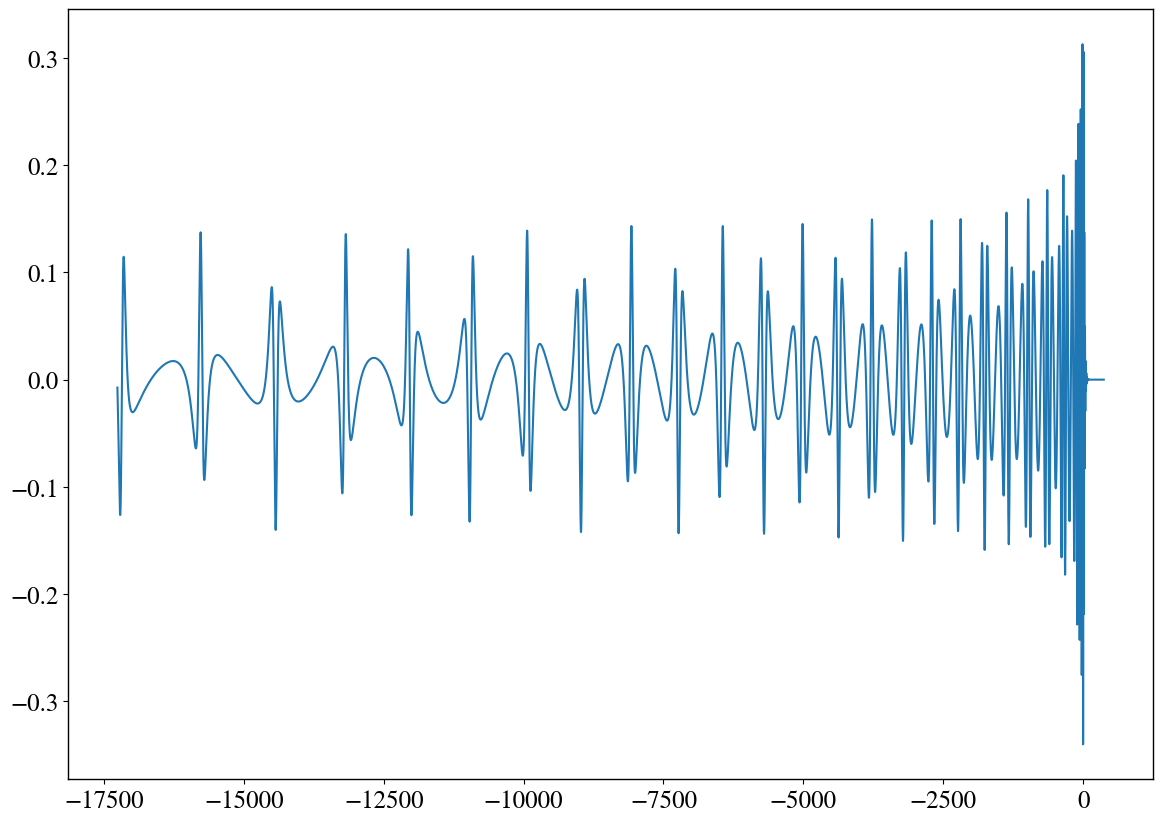

<IPython.core.display.Javascript object>

In [8]:
plt.plot(nr_waveform["t"], nr_waveform["hlm"][(2, 2)])

In [9]:
t_for_omega22_avg, omega22_avg = nr_results["gwecc_object"].get_omega22_average()
ind = np.argmin(np.abs(t_for_omega22_avg - t_ref))
omega22_ref = omega22_avg[ind]

<IPython.core.display.Javascript object>

In [10]:
nr_results = gw_eccentricity.gw_eccentricity.measure_eccentricity(
    fref_in=omega22_ref / 2 / np.pi, dataDict=nr_waveform
)

<IPython.core.display.Javascript object>

In [11]:
nr_results

{'eccentricity': 0.6507551883539415,
 'mean_anomaly': 3.141592653589777,
 'fref_out': 0.0016738303648159726,
 'gwecc_object': <gw_eccentricity.eccDefinitionUsingAmplitude.eccDefinitionUsingAmplitude at 0x14dc32dd1430>}

<IPython.core.display.Javascript object>

In [12]:
q = 2.0
chi1, chi2 = 0.0, 0.0
Mtot = 40.0
f_min = (0.96) * nr_results["fref_out"] / lal.MTSUN_SI / Mtot
delta_t = 1.0 / (4096.0) / 2.0
EccIC = -2
ecc_anomaly = nr_results["mean_anomaly"]
ecc = nr_results["eccentricity"] * (1.005)
approx = "SEOBNRv4EHM_opt"

(
    timeNRv4EHM,
    hlmv4EHM,
    amplmv4EHM,
    omegalmv4EHM,
    phaselmv4EHM,
    tdynv4EHM,
    rdynv4EHM,
    phidynv4EHM,
    omegaOrbitalv4EHM,
    prdynv4EHM,
    pphidynv4EHM,
) = SEOBNRv4EHM_modes(
    q, chi1, chi2, ecc, ecc_anomaly, f_min, Mtot, delta_t, EccIC, approx
)

Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_57435/1524896985.py", line 300, in SEOBNRv4EHM_modes
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_57435/1524896985.py", line 301, in SEOBNRv4EHM_modes
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_57435/1524896985.py", line 307, in SEOBNRv4EHM_modes
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_57435/1524896985.py", line 308, in SEOBNRv4EHM_modes
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_57435/1524896985.py", line 

<IPython.core.display.Javascript object>

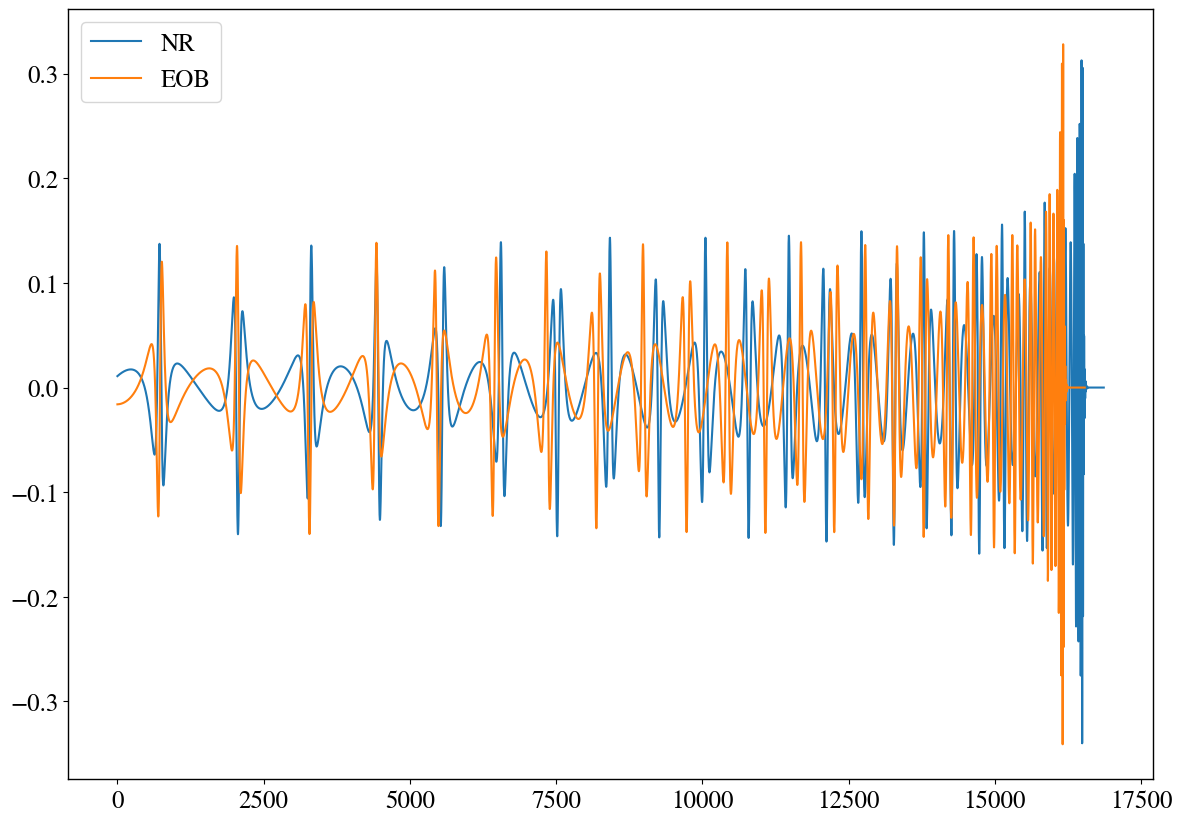

<IPython.core.display.Javascript object>

In [13]:
plt.plot(
    nr_waveform["t"][start_ind:] - nr_waveform["t"][start_ind],
    np.real(nr_waveform["hlm"][(2, 2)][start_ind:]),
    label="NR",
)
plt.plot(timeNRv4EHM - timeNRv4EHM[0], np.real(hlmv4EHM[2, 2]), label="EOB")
plt.legend()

Text(0, 0.5, 'abs(h_22)')

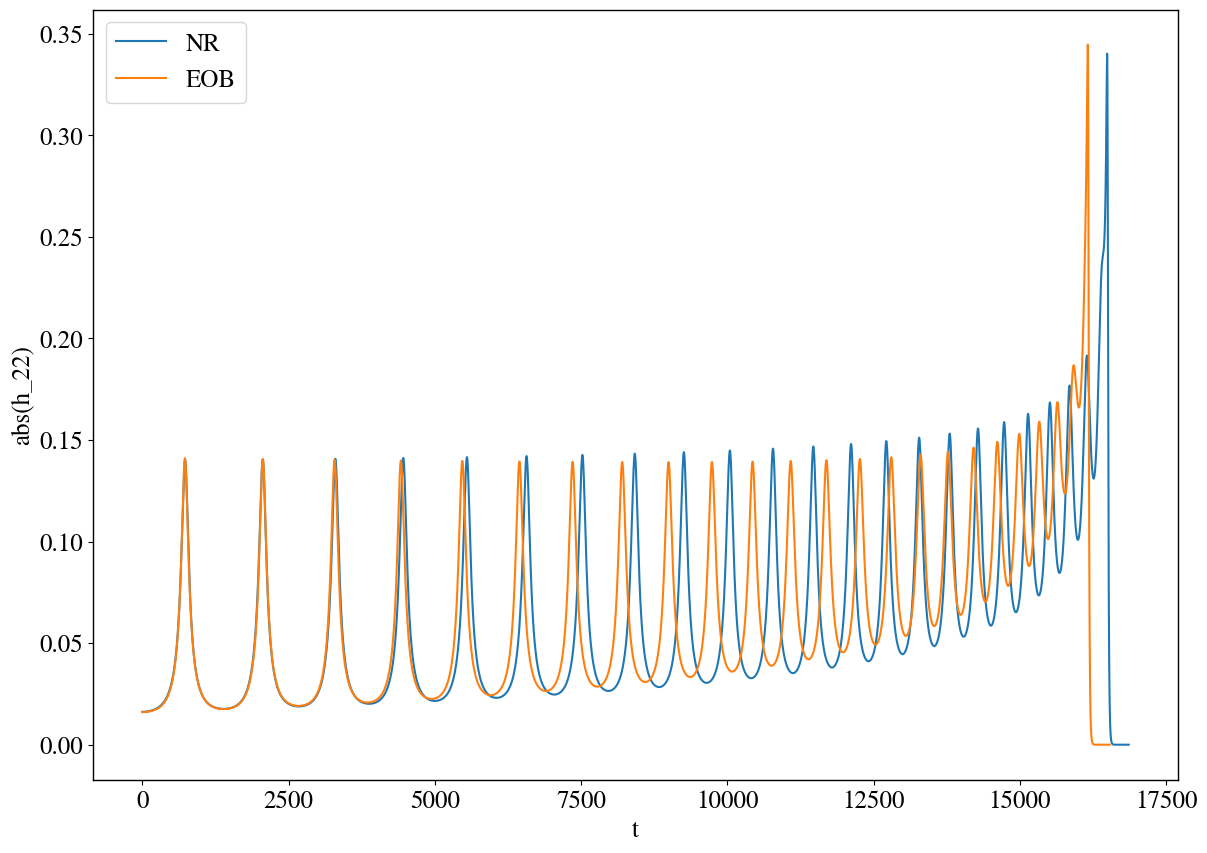

<IPython.core.display.Javascript object>

In [14]:
plt.plot(
    nr_waveform["t"][start_ind:] - nr_waveform["t"][start_ind:][0],
    np.abs(nr_waveform["hlm"][(2, 2)][start_ind:]),
    label="NR",
)
plt.plot(timeNRv4EHM - timeNRv4EHM[0], np.abs(hlmv4EHM[2, 2]), label="EOB")
plt.legend()
plt.xlabel("t")
plt.ylabel("abs(h_22)")

(0.016, 0.0165)

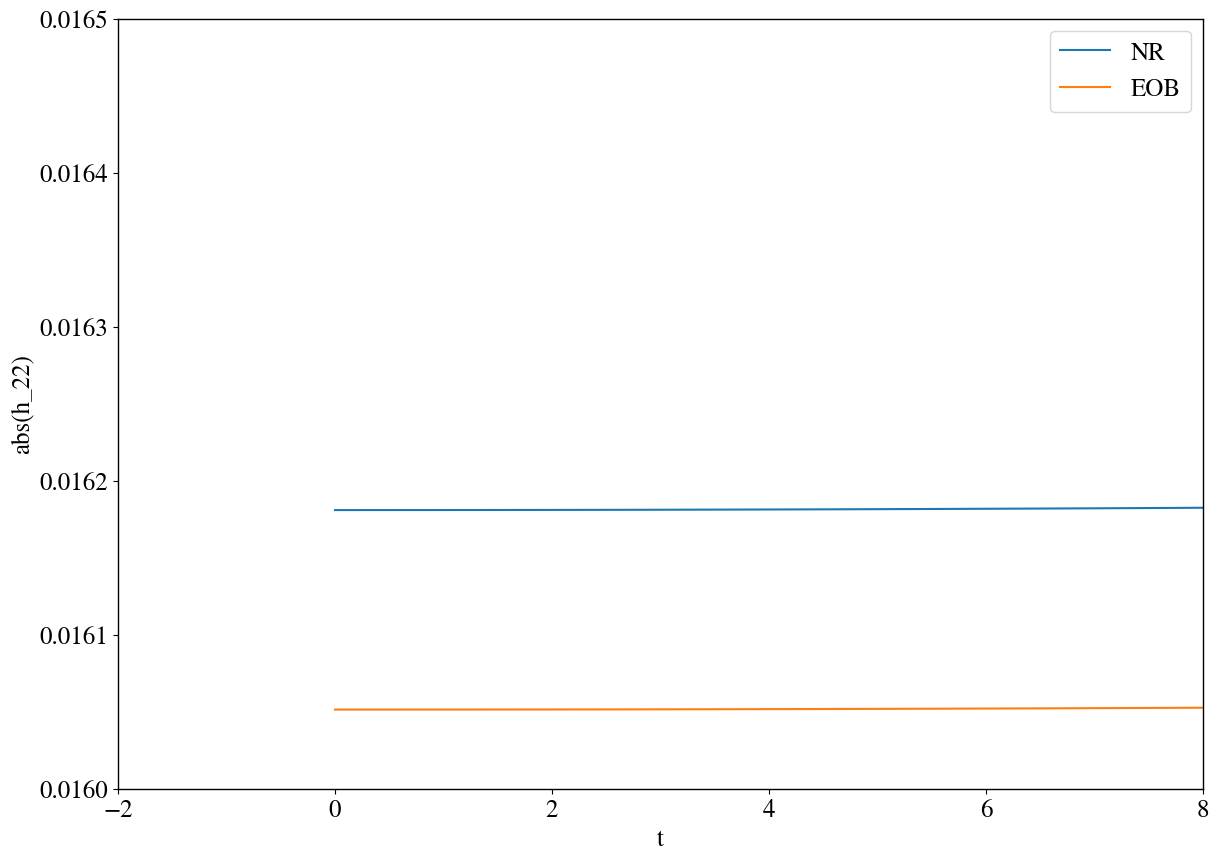

<IPython.core.display.Javascript object>

In [15]:
plt.plot(
    nr_waveform["t"][start_ind:] - nr_waveform["t"][start_ind:][0],
    np.abs(nr_waveform["hlm"][(2, 2)][start_ind:]),
    label="NR",
)
plt.plot(timeNRv4EHM - timeNRv4EHM[0], np.abs(hlmv4EHM[2, 2]), label="EOB")
plt.legend()
plt.xlabel("t")
plt.ylabel("abs(h_22)")
plt.xlim(-2, 8)
plt.ylim(0.016, 0.0165)

(0.05, 0.15)

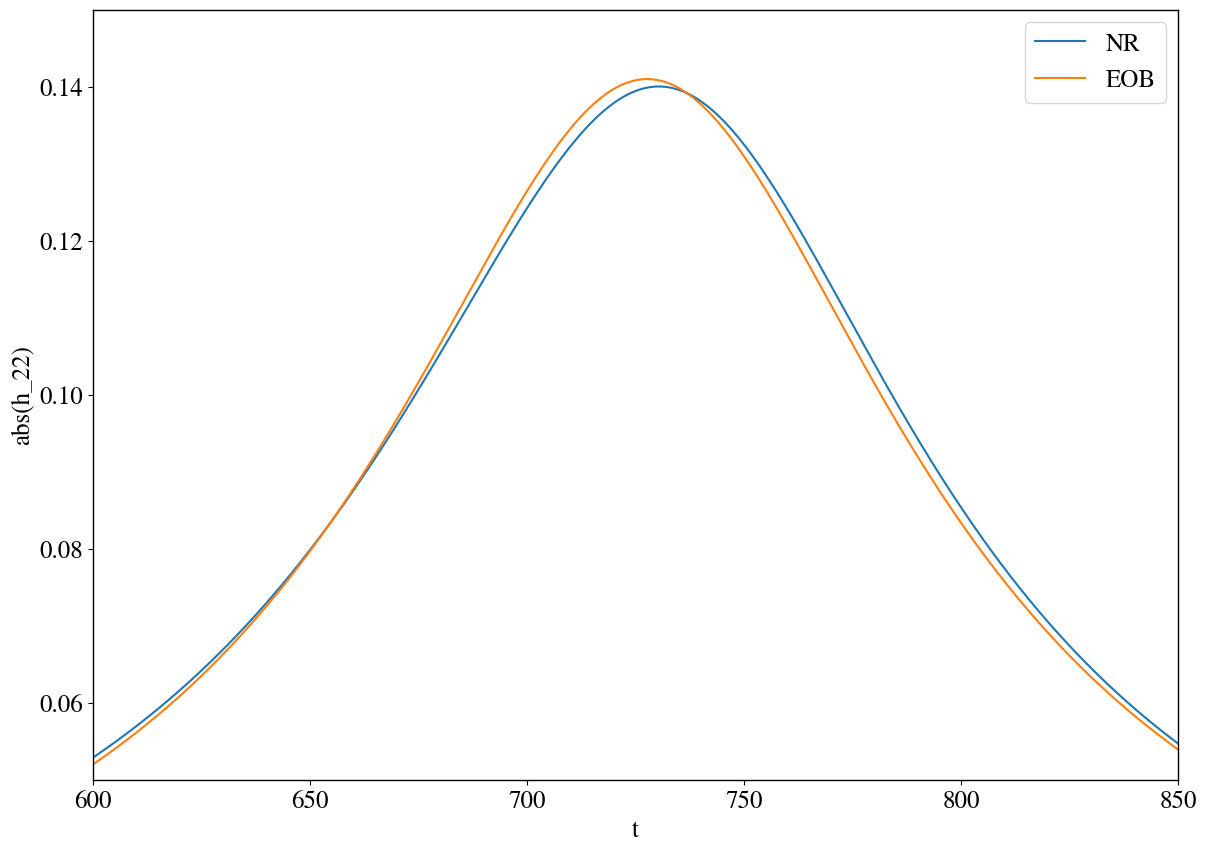

<IPython.core.display.Javascript object>

In [16]:
plt.plot(
    nr_waveform["t"][start_ind:] - nr_waveform["t"][start_ind:][0],
    np.abs(nr_waveform["hlm"][(2, 2)][start_ind:]),
    label="NR",
)
plt.plot(timeNRv4EHM - timeNRv4EHM[0], np.abs(hlmv4EHM[2, 2]), label="EOB")
plt.legend()
plt.xlabel("t")
plt.ylabel("abs(h_22)")
plt.xlim(600, 850)
plt.ylim(0.05, 0.15)

In [17]:
eob_dict = {}
eob_dict["hlm"] = {}
eob_dict["t"] = timeNRv4EHM
eob_dict["hlm"][(2, 2)] = hlmv4EHM[2, 2]

<IPython.core.display.Javascript object>

(0.0, 0.06)

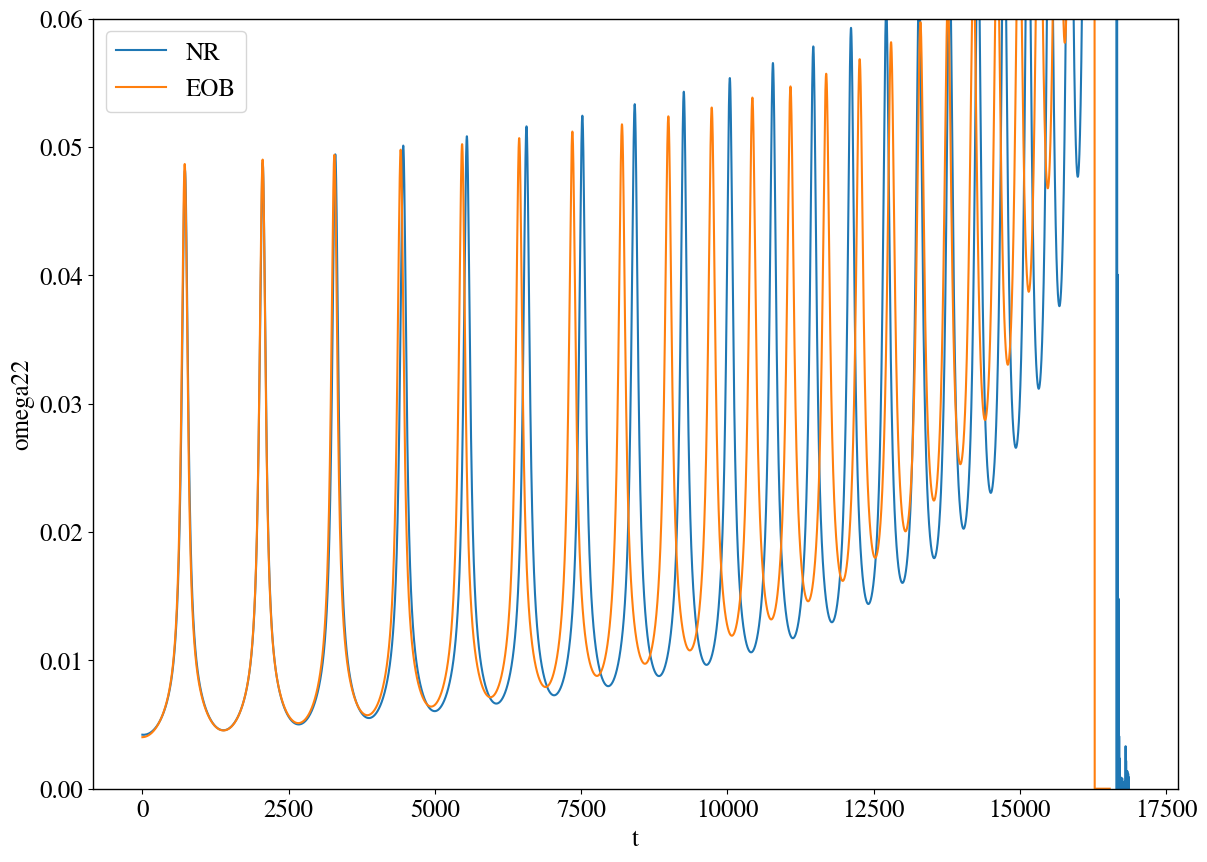

<IPython.core.display.Javascript object>

In [18]:
plt.plot(
    nr_waveform["t"][(start_ind + 1) :] - nr_waveform["t"][(start_ind + 1)],
    waveform_to_frequency(nr_waveform)[start_ind:],
    label="NR",
)

plt.plot(
    eob_dict["t"][1:] - eob_dict["t"][0], waveform_to_frequency(eob_dict), label="EOB"
)
plt.legend()
plt.xlabel("t")
plt.ylabel("omega22")
plt.ylim(0, 0.06)

In [19]:
f_min1 = f_min * (0.97)
ecc1 = ecc * (1.01)

(
    timeNRv4EHM1,
    hlmv4EHM1,
    amplmv4EHM1,
    omegalmv4EHM1,
    phaselmv4EHM1,
    tdynv4EHM1,
    rdynv4EHM1,
    phidynv4EHM1,
    omegaOrbitalv4EHM1,
    prdynv4EHM1,
    pphidynv4EHM1,
) = SEOBNRv4EHM_modes(
    q, chi1, chi2, ecc1, ecc_anomaly, f_min1, Mtot, delta_t, EccIC, approx
)

Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_57435/1524896985.py", line 300, in SEOBNRv4EHM_modes
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_57435/1524896985.py", line 301, in SEOBNRv4EHM_modes
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_57435/1524896985.py", line 307, in SEOBNRv4EHM_modes
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_57435/1524896985.py", line 308, in SEOBNRv4EHM_modes
RuntimeError: swiglal_restore_stdouterr() failed
Exception ignored in: '_wrap_delete_SphHarmTimeSeries'
Traceback (most recent call last):
  File "/tmp/ipykernel_57435/1524896985.py", line 

<IPython.core.display.Javascript object>

Text(0, 0.5, 'abs(h_22)')

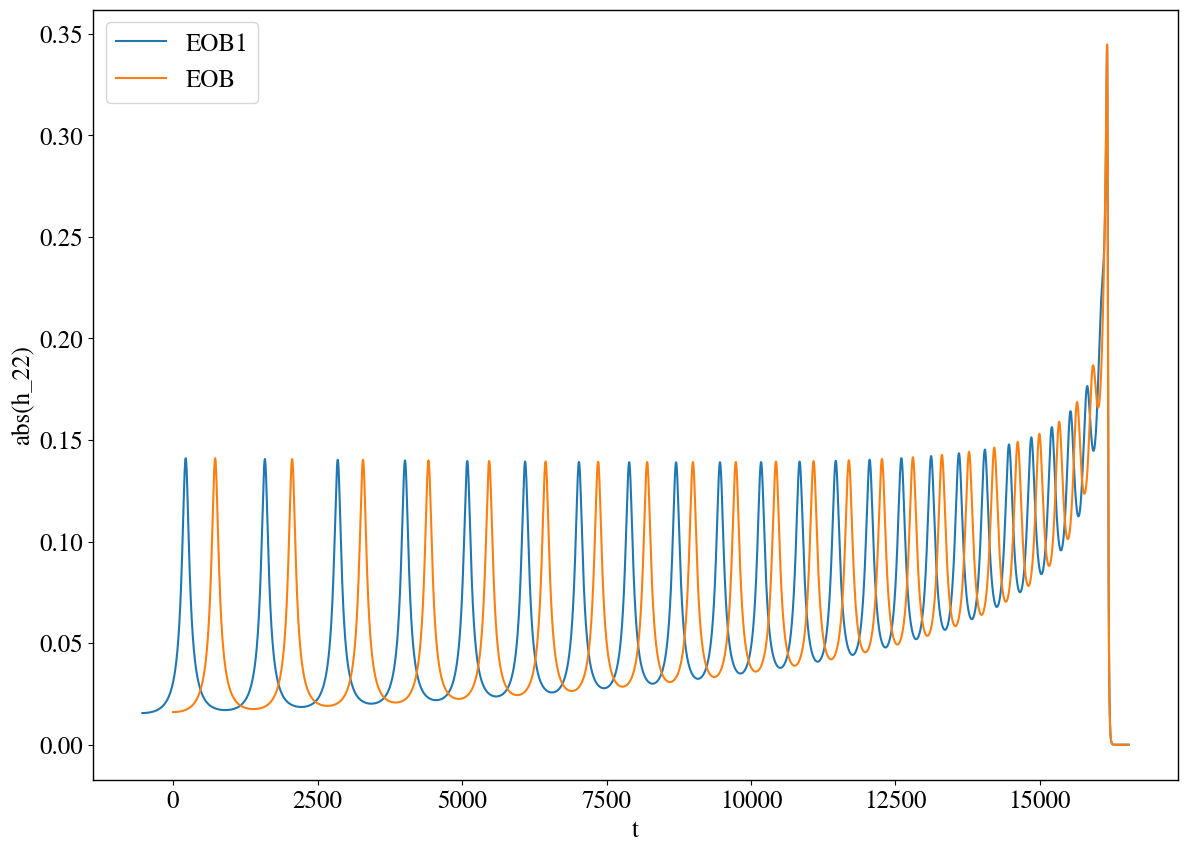

<IPython.core.display.Javascript object>

In [20]:
plt.plot(timeNRv4EHM1 - timeNRv4EHM[0], np.abs(hlmv4EHM1[2, 2]), label="EOB1")
plt.plot(timeNRv4EHM - timeNRv4EHM[0], np.abs(hlmv4EHM[2, 2]), label="EOB")
plt.legend()
plt.xlabel("t")
plt.ylabel("abs(h_22)")

In [21]:
eob_dict1 = {}
eob_dict1["hlm"] = {}
eob_dict1["t"] = timeNRv4EHM1
eob_dict1["hlm"][(2, 2)] = hlmv4EHM1[2, 2]

<IPython.core.display.Javascript object>

In [22]:
gw_eccentricity.gw_eccentricity.measure_eccentricity(fref_in=0.01, dataDict=eob_dict)

{'eccentricity': 0.16751280368630905,
 'mean_anomaly': 4.2371596017478055,
 'fref_out': 0.01,
 'gwecc_object': <gw_eccentricity.eccDefinitionUsingAmplitude.eccDefinitionUsingAmplitude at 0x14dc325462e0>}

<IPython.core.display.Javascript object>

In [23]:
gw_eccentricity.gw_eccentricity.measure_eccentricity(fref_in=0.01, dataDict=eob_dict1)

{'eccentricity': 0.16763765448101986,
 'mean_anomaly': 0.305495383189232,
 'fref_out': 0.01,
 'gwecc_object': <gw_eccentricity.eccDefinitionUsingAmplitude.eccDefinitionUsingAmplitude at 0x14dc32636e80>}

<IPython.core.display.Javascript object>

In [24]:
print(rdynv4EHM[0])
print(prdynv4EHM[0])
print(omegaOrbitalv4EHM[0])
print(pphidynv4EHM[0])

58.71523582808055
3.2129919793702735e-06
0.0013943572736599518
4.892944614782357


<IPython.core.display.Javascript object>

In [25]:
print(rdynv4EHM1[0])
print(prdynv4EHM1[0])
print(omegaOrbitalv4EHM1[0])
print(pphidynv4EHM1[0])

60.19741134707028
2.825677197065155e-06
0.0013307981041721616
4.906095532001147


<IPython.core.display.Javascript object>

In [26]:
print(rdynv4EHM1[0] / rdynv4EHM[0])
print(omegaOrbitalv4EHM1[0] / omegaOrbitalv4EHM[0])

1.0252434567976456
0.9544168695581454


<IPython.core.display.Javascript object>

In [34]:
print(60.00764510 * rdynv4EHM1[0] / rdynv4EHM[0])
print(0.00130320 * omegaOrbitalv4EHM1[0] / omegaOrbitalv4EHM[0])

61.5224454966103
0.0012437960644081751


<IPython.core.display.Javascript object>

In [27]:
print(np.abs(rdynv4EHM[0] - rdynv4EHM1[0]) / rdynv4EHM[0])
print(np.abs(omegaOrbitalv4EHM[0] - omegaOrbitalv4EHM1[0]) / omegaOrbitalv4EHM[0])

0.025243456797645652
0.045583130441854545


<IPython.core.display.Javascript object>

In [28]:
horizon = sxs.load(
    "/urania/ptmp/pjn/scratch_gitrepos/SimAnnex/Private/SurveyMeanAno/01/Lev3/Horizons"
)

<IPython.core.display.Javascript object>

In [29]:
mid = np.array(horizon.a.coord_center_inertial) - np.array(
    horizon.b.coord_center_inertial
)
sep = np.sqrt(mid[:, 0] ** 2 + mid[:, 1] ** 2 + mid[:, 2] ** 2)

<IPython.core.display.Javascript object>

In [30]:
sep

array([60.00764188, 60.00765182, 60.0076695 , ...,  2.31525466,
        2.20192453,  2.0811418 ])

<IPython.core.display.Javascript object>

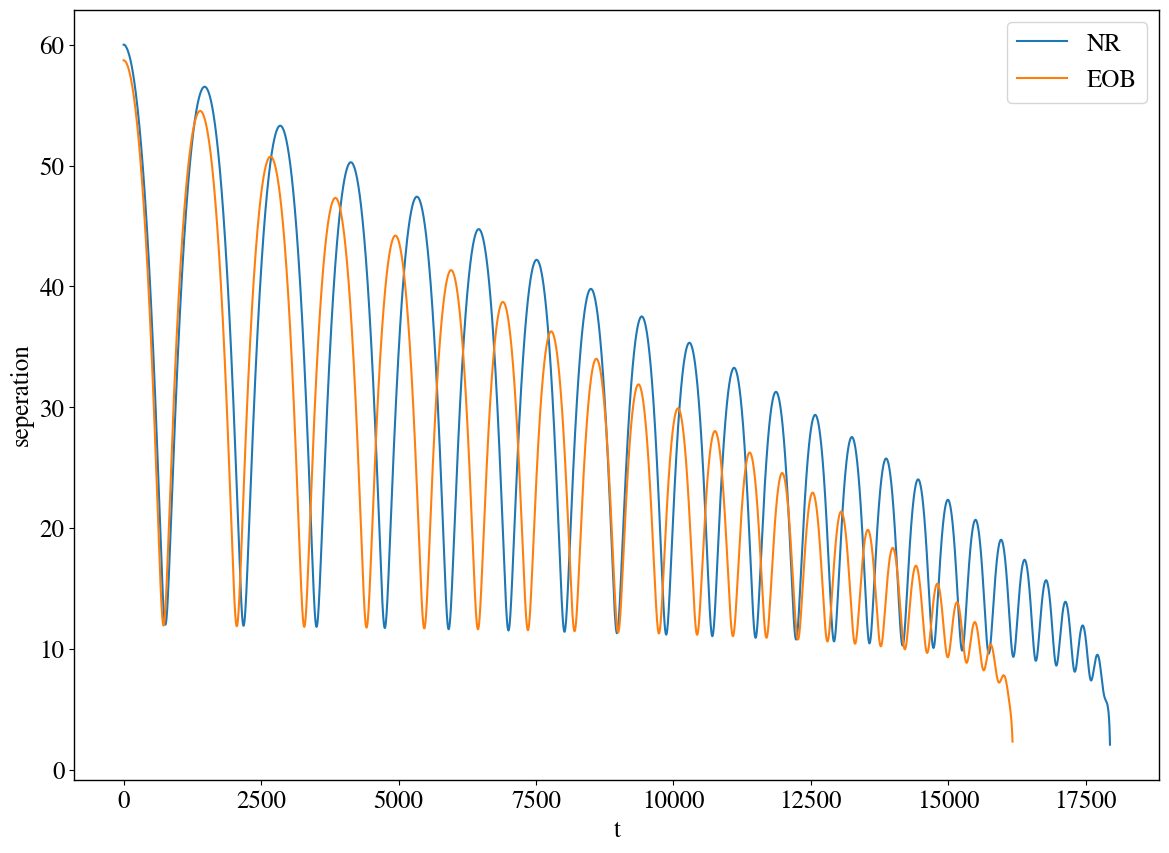

<IPython.core.display.Javascript object>

In [31]:
plt.plot(horizon.a.time, sep, label="NR")
plt.plot(tdynv4EHM - tdynv4EHM[0], rdynv4EHM, label="EOB")
plt.xlabel("t")
plt.ylabel("seperation")
plt.legend()

In [32]:
print(prdynv4EHM1[0] / lal.MTSUN_SI / Mtot / Mtot)
print(omegaOrbitalv4EHM1[0])

0.000358552728856271
0.0013307981041721616


<IPython.core.display.Javascript object>